The goal of this project is to predict the chance of survival based on some data such as social class, sex, age, cabin, embarked and other features that can effect chance of survival.

In [ ]:
from sklearn.datasets import fetch_openml

from pathlib import Path
import tarfile
import urllib.request

import joblib

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, train_test_split, GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import randint
from scipy.ndimage.interpolation import shift

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

<ipython-input-1-ded1f52b1e47>:27: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [ ]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Download the data

In [ ]:
def load_titanic_data():
    path = "/content/drive/MyDrive/Hands on ML/chap.3/Datasets"
    tarball_path = Path(path + "/titanic.tgz")
    if not tarball_path.is_file():
        Path(path).mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path=path)
    train_df = pd.read_csv(Path(path + "/titanic/train.csv"))
    test_df = pd.read_csv(Path(path + "/titanic/test.csv"))
    return train_df, test_df
train_df, test_df = load_titanic_data()

## Take a quick look at data structure

In [ ]:
train = train_df.copy()
test = test_df.copy()

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train['Pclass'].value_counts()

,count
Pclass,
3,491
1,216
2,184


In [ ]:
train['Survived'].value_counts()

,count
Survived,
0,549
1,342


In [ ]:
train['Sex'].value_counts()

,count
Sex,
male,577
female,314


In [ ]:
((train['Sex'] == 'female') & (train['Survived'] == 1)).value_counts()

,count
False,658
True,233


In [ ]:
women = train.loc[train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [ ]:
men = train.loc[train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [ ]:
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train[features])
X.head()

,Pclass,SibSp,Parch,Sex_female,Sex_male
0,3,1,0,False,True
1,1,1,0,True,False
2,3,0,0,True,False
3,1,1,0,True,False
4,3,0,0,False,True


In [ ]:
train['SibSp'].value_counts()

,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


In [ ]:
train['Parch'].value_counts()

,count
Parch,
0,678
1,118
2,80
5,5
3,5
4,4
6,1


In [ ]:
(train['Ticket'].value_counts()).head(10)

,count
Ticket,
347082,7
CA. 2343,7
1601,7
3101295,6
CA 2144,6
347088,6
S.O.C. 14879,5
382652,5
LINE,4


In [ ]:
(train['Fare'].value_counts()).head()

,count
Fare,
8.0500,43
13.0000,42
7.8958,38
7.7500,34
26.0000,31


In [ ]:
(train['Cabin'].value_counts()).head()

,count
Cabin,
B96 B98,4
G6,4
C23 C25 C27,4
C22 C26,3
F33,3


In [ ]:
train['Embarked'].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [ ]:
train.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [ ]:
train.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
train.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [ ]:
train.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
train.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [ ]:
train.groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [ ]:
train.groupby(['Pclass'], as_index=False)['Age'].agg(['count', 'mean'])

,Pclass,count,mean
0,1,186,38.233423
1,2,173,29.877649
2,3,355,25.140610



# **Discover and visualize the Data to get Insights**





## Visualize the data

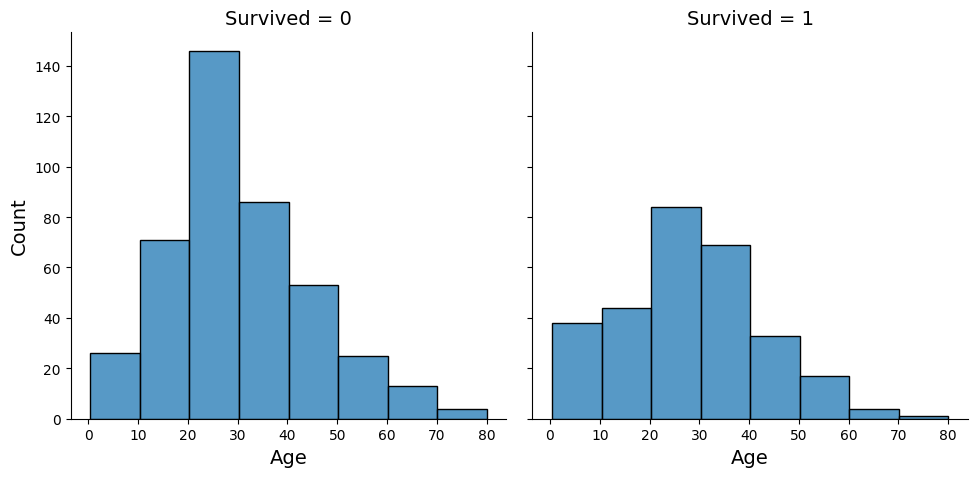

In [ ]:
sns.displot(train, x='Age', col='Survived', binwidth=10, height=5)

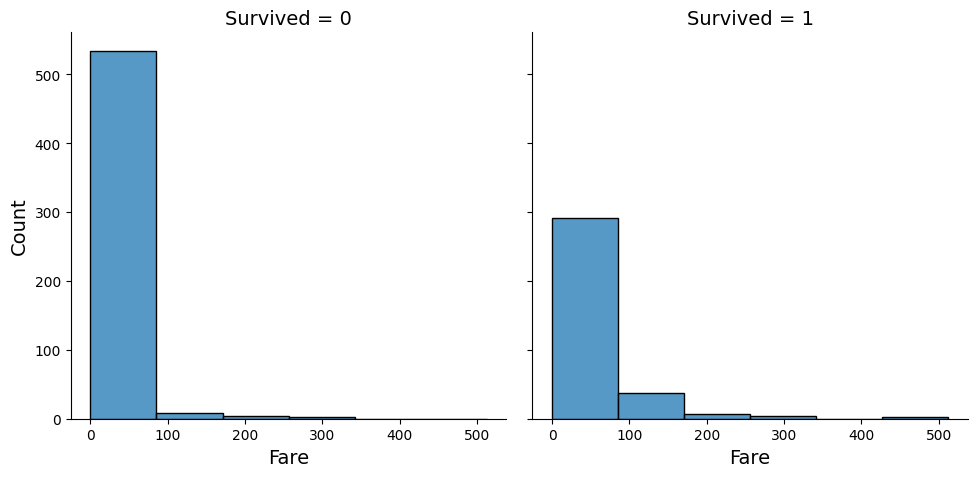

In [ ]:
sns.displot(train, x='Fare', col='Survived', binwidth=80, height=5)

## Looking for correlations

In [ ]:
corr_matrix = train.corr(numeric_only=True)

corr_matrix['Survived'].sort_values(ascending=False)

,Survived
Survived,1.000000
Fare,0.257307
Parch,0.081629
PassengerId,-0.005007
SibSp,-0.035322
Age,-0.077221
Pclass,-0.338481


# **Prepare the data for ML alghorithm**

## Data Cleaning and Feature Scaling

### *Handling SibSb and Parch column*

In [ ]:
train['Family_Size'] = train['SibSp'] + train['Parch'] + 1
test['Family_Size'] = test['SibSp'] + test['Parch'] + 1

In [ ]:
train.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [ ]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium',
              6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
train['Family_Size_Grouped'] = train['Family_Size'].map(family_map)
test['Family_Size_Grouped'] = test['Family_Size'].map(family_map)

In [ ]:
(train.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()).sort_values(by='Survived', ascending=False)

,Family_Size_Grouped,Survived
3,Small,0.578767
0,Alone,0.303538
2,Medium,0.162162
1,Large,0.160000


### *Handling Age Column*

In [ ]:
train.groupby(['Pclass'], as_index=False)['Age'].mean()

,Pclass,Age
0,1,38.233423
1,2,29.877649
2,3,25.140610


In [ ]:
mean_ages = ((train.groupby(['Pclass'], as_index=False)['Age'].mean()).round(0))['Age']
mean_ages

,Age
0,38.0
1,30.0
2,25.0


In [ ]:
null_age_indices = train['Age'].loc[train['Age'].isnull()]
train.iloc[null_age_indices.index].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,Alone
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,Alone
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1,Alone
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,1,Alone
28,29,1,3,"O'Dwyer, Miss. Ellen 'Nellie'",female,NaN,0,0,330959,7.8792,NaN,Q,1,Alone


In [ ]:
train['Age'] = train.apply(lambda row: mean_ages[int(row['Pclass'])-1] if pd.isnull(row['Age']) else row['Age'], axis=1)

In [ ]:
train.iloc[null_age_indices.index].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,1,Alone
17,18,1,2,"Williams, Mr. Charles Eugene",male,30.0,0,0,244373,13.0000,NaN,S,1,Alone
19,20,1,3,"Masselmani, Mrs. Fatima",female,25.0,0,0,2649,7.2250,NaN,C,1,Alone
26,27,0,3,"Emir, Mr. Farred Chehab",male,25.0,0,0,2631,7.2250,NaN,C,1,Alone
28,29,1,3,"O'Dwyer, Miss. Ellen 'Nellie'",female,25.0,0,0,330959,7.8792,NaN,Q,1,Alone


In [ ]:
train['Age_Cut'] = pd.qcut(train['Age'], 5)
test['Age_Cut'] = pd.qcut(test['Age'], 5)

In [ ]:
train.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

<ipython-input-45-d789925a1c57>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['Age_Cut'], as_index=False)['Survived'].mean()


,Age_Cut,Survived
0,"(0.416, 20.0]",0.458101
1,"(20.0, 25.0]",0.294574
2,"(25.0, 30.0]",0.386555
3,"(30.0, 38.0]",0.455696
4,"(38.0, 80.0]",0.372881


In [ ]:
train['Age_Cut'].value_counts()

,count
Age_Cut,
"(20.0, 25.0]",258
"(0.416, 20.0]",179
"(38.0, 80.0]",177
"(30.0, 38.0]",158
"(25.0, 30.0]",119


In [ ]:
bins = [0., 19.0, 25.0, 31.8, 41.0, 80.0]
labels = [0, 1, 2, 3, 4]
train['Age_Cat'] = pd.cut(train['Age'], bins=bins, labels=labels)
test['Age_Cat'] = pd.cut(test['Age'], bins=bins, labels=labels)

### *Handling Fare column*

In [ ]:
train['Fare_Cut'] = pd.qcut(train['Fare'], 6)
test['Fare_Cut'] = pd.qcut(test['Fare'], 6)

In [ ]:
train['Fare_Cut'].value_counts()

,count
Fare_Cut,
"(-0.001, 7.775]",156
"(7.775, 8.662]",152
"(14.454, 26.0]",149
"(52.369, 512.329]",149
"(26.0, 52.369]",146
"(8.662, 14.454]",139


In [ ]:
train.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()

<ipython-input-50-4ce03276d046>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()


,Fare_Cut,Survived
0,"(-0.001, 7.775]",0.205128
1,"(7.775, 8.662]",0.190789
2,"(8.662, 14.454]",0.366906
3,"(14.454, 26.0]",0.436242
4,"(26.0, 52.369]",0.417808
5,"(52.369, 512.329]",0.697987


In [ ]:
bins = [0., 8.662, 14.454, 26.0, 52.369, 512.329]
labels = [0, 1, 2, 3, 4]
train['Fare_Cat'] = pd.cut(train['Fare'], bins=bins, labels=labels)
test['Fare_Cat'] = pd.cut(test['Fare'], bins=bins, labels=labels)

In [ ]:
SI = SimpleImputer(strategy='most_frequent')

train['Fare_Cat'] = SI.fit_transform(train[['Fare_Cat']])

## Handling Text and Categorical Attributes

### *Handling Name column*

In [ ]:
train['Title'] =  train['Name'].str.split(pat=',', expand=True)[1].str.split(pat='.', expand=True)[0].apply(lambda x: x.strip())
test['Title'] =  test['Name'].str.split(pat=',', expand=True)[1].str.split(pat='.', expand=True)[0].apply(lambda x: x.strip())

In [ ]:
train.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [ ]:
train.groupby(['Title'], as_index=False)['Survived'].value_counts()

,Title,Survived,count
0,Capt,0,1
1,Col,0,1
2,Col,1,1
3,Don,0,1
4,Dr,0,4
5,Dr,1,3
6,Jonkheer,0,1
7,Lady,1,1
8,Major,1,1
9,Major,0,1


In [ ]:
train['Title'] = train['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'
})

test['Title'] = test['Title'].replace({
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'
})

In [ ]:
train.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


In [ ]:
train.groupby(['Title'], as_index=False)['Survived'].value_counts()

,Title,Survived,count
0,Dr,0,4
1,Dr,1,3
2,Master,1,23
3,Master,0,17
4,Military,0,3
5,Military,1,2
6,Miss,1,127
7,Miss,0,55
8,Mr,0,436
9,Mr,1,81


In [ ]:
train['Name_Length'] = train['Name'].apply(lambda x: len(x))
test['Name_Length'] = test['Name'].apply(lambda x: len(x))

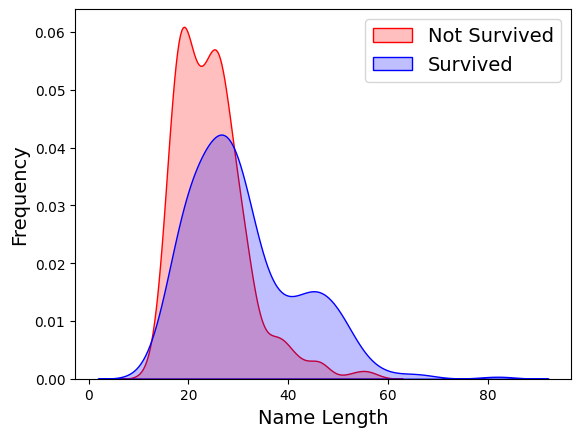

In [ ]:
g = sns.kdeplot(train['Name_Length'][(train['Survived']==0) & (train['Name_Length'].notnull())], color='Red', fill=True)
g = sns.kdeplot(train['Name_Length'][(train['Survived']==1) & (train['Name_Length'].notnull())], ax=g, color='Blue', fill=True)
g.set_xlabel('Name Length')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [ ]:
train['Name_LengthGB'] = pd.qcut(train['Name_Length'],6)
test['Name_LengthGB'] = pd.qcut(test['Name_Length'], 6)

In [ ]:
train.groupby(['Name_LengthGB'], as_index=False)['Survived'].agg(['count', 'mean'])

<ipython-input-62-0dca96cd18fc>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['Name_LengthGB'], as_index=False)['Survived'].agg(['count', 'mean'])


,Name_LengthGB,count,mean
0,"(11.999, 19.0]",204,0.220588
1,"(19.0, 22.0]",117,0.307692
2,"(22.0, 25.0]",137,0.328467
3,"(25.0, 28.0]",142,0.316901
4,"(28.0, 33.0]",144,0.479167
5,"(33.0, 82.0]",147,0.693878


In [ ]:
bins = [0., 19.0, 28.0, 35.0, 82.0]
labels = [0, 1, 2, 3]
train['Name_Length_cat'] = pd.cut(train['Name_Length'], bins=bins, labels=labels)
test['Name_Length_cat'] = pd.cut(test['Name_Length'], bins=bins, labels=labels)

### *Handling Ticket Column*

In [ ]:
train['TicketNumber'] = train['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test['TicketNumber'] = test['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [ ]:
train.groupby(['TicketNumber'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False).head(15)

,TicketNumber,count,mean
464,347082,7,0.000000
196,2343,7,0.000000
94,1601,7,0.714286
168,2144,6,0.000000
468,347088,6,0.000000
358,3101295,6,0.000000
615,382652,5,0.000000
90,14879,5,0.000000
678,LINE,4,0.250000
35,113760,4,1.000000


In [ ]:
train.groupby('TicketNumber')['TicketNumber'].transform('count').head()

,TicketNumber
0,1
1,1
2,1
3,2
4,1


In [ ]:
train['TicketNumbetCounts'] = train.groupby('TicketNumber')['TicketNumber'].transform('count')
test['TicketNumbetCounts'] = test.groupby('TicketNumber')['TicketNumber'].transform('count')

In [ ]:
train.groupby(['TicketNumbetCounts'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumbetCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [ ]:
train['Ticket'].str.split(pat=' ', expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [ ]:
train['TicketLocation'] = np.where(train['Ticket'].str.split(pat=' ', expand=True)[1].notna(),
                                   train['Ticket'].str.split(pat=' ', expand=True)[0].apply(lambda x: x.strip()),
                                   'Blank')
test['TicketLocation'] = np.where(test['Ticket'].str.split(pat=' ', expand=True)[1].notna(),
                                   test['Ticket'].str.split(pat=' ', expand=True)[0].apply(lambda x: x.strip()),
                                   'Blank')

In [ ]:
train['TicketLocation'].value_counts()

,count
TicketLocation,
Blank,665
PC,60
C.A.,27
STON/O,12
A/5,10
W./C.,9
CA.,8
SOTON/O.Q.,8
SOTON/OQ,7


In [ ]:
train['TicketLocation'] = train['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C'
})

test['TicketLocation'] = test['TicketLocation'].replace({
    'SOTON/O.Q.':'SOTON/OQ',
    'C.A.':'CA',
    'CA.':'CA',
    'SC/PARIS':'SC/Paris',
    'S.C./PARIS':'SC/Paris',
    'A/4.':'A/4',
    'A/5.':'A/5',
    'A.5.':'A/5',
    'A./5.':'A/5',
    'W./C.':'W/C'
})

In [ ]:
train.groupby(['TicketLocation'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


### *Handling cabin column*

In [ ]:
train['Cabin'] = train['Cabin'].fillna('U')
train['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'x' for i in train['Cabin'])

test['Cabin'] = test['Cabin'].fillna('U')
test['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'x' for i in test['Cabin'])

In [ ]:
train.groupby(['Cabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [ ]:
train['Cabin_Assigned'] = train['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test['Cabin_Assigned'] = test['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [ ]:
train.groupby(['Cabin_Assigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Survived             891 non-null    int64   
 2   Pclass               891 non-null    int64   
 3   Name                 891 non-null    object  
 4   Sex                  891 non-null    object  
 5   Age                  891 non-null    float64 
 6   SibSp                891 non-null    int64   
 7   Parch                891 non-null    int64   
 8   Ticket               891 non-null    object  
 9   Fare                 891 non-null    float64 
 10  Cabin                891 non-null    object  
 11  Embarked             889 non-null    object  
 12  Family_Size          891 non-null    int64   
 13  Family_Size_Grouped  891 non-null    object  
 14  Age_Cut              891 non-null    category
 15  Age_Cat              89

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    float64 
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_Size          418 non-null    int64   
 12  Family_Size_Grouped  418 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Age_Cat              332 non-null    category
 15  Fare_Cut             41

## Removing some columns and Manipulate

In [ ]:
X_train = train.drop(['Survived', 'SibSp', 'Parch', 'Age_Cut',
                      'Fare_Cut', 'Family_Size', 'Name_LengthGB',
                      'Name_Length', 'TicketNumber'], axis=1)
y_train = train['Survived']

X_test = test.drop(['SibSp', 'Parch', 'Age_Cut',
                      'Fare_Cut', 'Family_Size', 'Name_LengthGB',
                      'Name_Length', 'TicketNumber'], axis=1)

In [ ]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_Size_Grouped,Age_Cat,Fare_Cat,Title,Name_Length_cat,TicketNumbetCounts,TicketLocation,Cabin_Assigned
0,1,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,U,S,Small,1,0.0,Mr,1,1,A/5,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,C,Small,3,4.0,Mrs,3,1,PC,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,U,S,Alone,2,0.0,Miss,1,1,STON/O2.,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C,S,Small,3,4.0,Mrs,3,2,Blank,1
4,5,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,U,S,Alone,3,0.0,Mr,1,1,Blank,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Pclass               891 non-null    int64   
 2   Name                 891 non-null    object  
 3   Sex                  891 non-null    object  
 4   Age                  891 non-null    float64 
 5   Ticket               891 non-null    object  
 6   Fare                 891 non-null    float64 
 7   Cabin                891 non-null    object  
 8   Embarked             889 non-null    object  
 9   Family_Size_Grouped  891 non-null    object  
 10  Age_Cat              891 non-null    category
 11  Fare_Cat             891 non-null    float64 
 12  Title                891 non-null    object  
 13  Name_Length_cat      891 non-null    category
 14  TicketNumbetCounts   891 non-null    int64   
 15  TicketLocation       89

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [ ]:
X_train['Age_Cat'] = X_train['Age_Cat'].astype('float64')

In [ ]:
X_train['Name_Length_cat'] = X_train['Name_Length_cat'].astype('float64')

In [ ]:
X_train['Cabin_Assigned'] = X_train['Cabin_Assigned'].astype('float64')

In [ ]:
X_train['TicketNumbetCounts'] = X_train['TicketNumbetCounts'].astype('float64')

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Pclass               891 non-null    int64  
 2   Name                 891 non-null    object 
 3   Sex                  891 non-null    object 
 4   Age                  891 non-null    float64
 5   Ticket               891 non-null    object 
 6   Fare                 891 non-null    float64
 7   Cabin                891 non-null    object 
 8   Embarked             889 non-null    object 
 9   Family_Size_Grouped  891 non-null    object 
 10  Age_Cat              891 non-null    float64
 11  Fare_Cat             891 non-null    float64
 12  Title                891 non-null    object 
 13  Name_Length_cat      891 non-null    float64
 14  TicketNumbetCounts   891 non-null    float64
 15  TicketLocation       891 non-null    obj

## Transformation pipeline

In [ ]:
ode_cols = ['Family_Size_Grouped']
ohe_cols = ['Title', 'Pclass', 'Sex', 'Embarked', 'Cabin_Assigned']

ordinal_pipeline = Pipeline([
    ('ord_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

one_hot_pipeline = Pipeline([
    ('ohe_imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [ ]:
preprocessing = ColumnTransformer([
    ('ordinal_pipeline', ordinal_pipeline, ode_cols),
    ('one_hot_pipeline', one_hot_pipeline, ohe_cols),
    ('passthrough', 'passthrough', ['Age_Cat', 'Fare_Cat', 'Name_Length_cat', 'TicketNumbetCounts'])
    ],
    remainder='drop', n_jobs=-1
)

In [ ]:
preprocessing.fit(X_train)

ColumnTransformer(n_jobs=-1,
                  transformers=[('ordinal_pipeline',
                                 Pipeline(steps=[('ord_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Family_Size_Grouped']),
                                ('one_hot_pipeline',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Title', 'Pclass', 'Sex', 'Embarked',
                                  'Cabin_Assigned']),
                                ('passthrough', 'passthrough',
                                 ['Age_Cat', 'Fare_Cat', 'Name_Length_cat',
                                  'TicketNumbetCounts'])])

In [ ]:
preprocessing.get_feature_names_out()

array(['ordinal_pipeline__Family_Size_Grouped',
       'one_hot_pipeline__Title_Dr', 'one_hot_pipeline__Title_Master',
       'one_hot_pipeline__Title_Military', 'one_hot_pipeline__Title_Miss',
       'one_hot_pipeline__Title_Mr', 'one_hot_pipeline__Title_Mrs',
       'one_hot_pipeline__Title_Noble', 'one_hot_pipeline__Title_Rev',
       'one_hot_pipeline__Pclass_1', 'one_hot_pipeline__Pclass_2',
       'one_hot_pipeline__Pclass_3', 'one_hot_pipeline__Sex_female',
       'one_hot_pipeline__Sex_male', 'one_hot_pipeline__Embarked_C',
       'one_hot_pipeline__Embarked_Q', 'one_hot_pipeline__Embarked_S',
       'one_hot_pipeline__Cabin_Assigned_0',
       'one_hot_pipeline__Cabin_Assigned_1', 'passthrough__Age_Cat',
       'passthrough__Fare_Cat', 'passthrough__Name_Length_cat',
       'passthrough__TicketNumbetCounts'], dtype=object)

# **Select, Train and Fine tune the model**

## Random Forest Classifier

In [ ]:
pipe_final_rfc = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest_classifier', RandomForestClassifier(random_state=42))
])

In [ ]:
rdc_scores = cross_val_score(pipe_final_rfc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
rdc_scores

array([0.74444444, 0.80898876, 0.73033708, 0.85393258, 0.82022472,
       0.80898876, 0.76404494, 0.76404494, 0.85393258, 0.85393258])

In [ ]:
param_grid = {
    'random_forest_classifier__n_estimators': [150, 200, 300, 500],
    'random_forest_classifier__min_samples_split': [5, 10, 15],
    'random_forest_classifier__max_depth': [10, 13, 15, 17, 20],
    'random_forest_classifier__min_samples_leaf': [2, 4, 5, 6],
    'random_forest_classifier__criterion': ['gini', 'entropy'],
}

In [ ]:
CV_rfc = GridSearchCV(estimator=pipe_final_rfc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest_classifier__criterion': ['gini',
                                                                 'entropy'],
                         'random_forest_classifier__max_depth': [10, 13, 15, 17,
                                                                 20],
                         'random_forest_classifier__min_samples_leaf': [2, 4, 5,
                                                                        6],
                         'random_forest_classifier__min_samples_split': [5, 10,
                                                                         15],
                         'random_forest_classifier__n_estimators': [150, 200,
                                                                    300, 500]},
             scoring='accuracy')

In [ ]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'random_forest_classifier__criterion': 'gini', 'random_forest_classifier__max_depth': 13, 'random_forest_classifier__min_samples_leaf': 4, 'random_forest_classifier__min_samples_split': 10, 'random_forest_classifier__n_estimators': 300}
0.827154604230745


## Decision Tree Classifier

In [ ]:
pipe_final_dtc = Pipeline([
    ('preprocessing', preprocessing),
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42))
])

In [ ]:
dtc_scores = cross_val_score(pipe_final_dtc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
dtc_scores

array([0.66666667, 0.82022472, 0.71910112, 0.83146067, 0.7752809 ,
       0.83146067, 0.74157303, 0.76404494, 0.83146067, 0.84269663])

In [ ]:
param_grid = {
    'decision_tree_classifier__min_samples_split': [5, 10, 15],
    'decision_tree_classifier__max_depth': [10, 20, 30],
    'decision_tree_classifier__min_samples_leaf': [1, 2, 4],
    'decision_tree_classifier__criterion': ['gini', 'entropy'],
}

In [ ]:
CV_dtc = GridSearchCV(estimator=pipe_final_dtc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_dtc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('decision_tree_classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decision_tree_classifier__criterion': ['gini',
                                                                 'entropy'],
                         'decision_tree_classifier__max_depth': [10, 20, 30],
                         'decision_tree_classifier__min_samples_leaf': [1, 2,
                                                                        4],
                         'decision_tree_classifier__min_samples_split': [5, 10,
                                                                         15]},
             scoring='accuracy')

In [ ]:
print(CV_dtc.best_params_)
print(CV_dtc.best_score_)

{'decision_tree_classifier__criterion': 'entropy', 'decision_tree_classifier__max_depth': 20, 'decision_tree_classifier__min_samples_leaf': 4, 'decision_tree_classifier__min_samples_split': 15}
0.8103571652752496


## K Neighbors Classifier

In [ ]:
pipe_final_knc = Pipeline([
    ('preprocessing', preprocessing),
    ('kneighbor_classifier', KNeighborsClassifier())
])

In [ ]:
knc_scores = cross_val_score(pipe_final_knc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
knc_scores

array([0.83333333, 0.83146067, 0.73033708, 0.85393258, 0.85393258,
       0.82022472, 0.78651685, 0.7752809 , 0.82022472, 0.82022472])

In [ ]:
param_grid = {
    'kneighbor_classifier__n_neighbors': [3, 5, 7, 9, 11],
    'kneighbor_classifier__weights': ['uniform', 'distance'],
    'kneighbor_classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighbor_classifier__p': [1,2],
}

In [ ]:
CV_knc = GridSearchCV(estimator=pipe_final_knc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_knc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('kneighbor_classifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighbor_classifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighbor_classifier__n_neighbors': [3, 5, 7, 9, 11],
                         'kneighbor_classifier__p': [1, 2],
                         'kneighbor_classifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [ ]:
print(CV_knc.best_params_)
print(CV_knc.best_score_)

{'kneighbor_classifier__algorithm': 'auto', 'kneighbor_classifier__n_neighbors': 7, 'kneighbor_classifier__p': 2, 'kneighbor_classifier__weights': 'uniform'}
0.8181972255351202


## SVC

In [ ]:
pipe_final_svc = Pipeline([
    ('preprocessing', preprocessing),
    ('svc', SVC(probability=True, random_state=42))
])

In [ ]:
svm_scores = cross_val_score(pipe_final_svc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
svm_scores

array([0.83333333, 0.87640449, 0.7752809 , 0.87640449, 0.80898876,
       0.79775281, 0.82022472, 0.78651685, 0.87640449, 0.85393258])

In [ ]:
param_grid = {
    'svc__C': [100,10, 1.0, 0.1, 0.001, 0.001],
    'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
}

In [ ]:
CV_svc = GridSearchCV(estimator=pipe_final_svc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_svc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Title',
                                                                          'Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Cabin_Assigned']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=42))]),
             param_grid={'svc__C': [100, 10, 1.0, 0.1, 0.001, 0.001],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [ ]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'svc__C': 1.0, 'svc__kernel': 'rbf'}
0.8293704098926622


## Logistic Regression

In [ ]:
pipe_final_lr = Pipeline([
    ('preprocessing', preprocessing),
    ('lr', LogisticRegression())
])

In [ ]:
lr_scores = cross_val_score(pipe_final_lr, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
lr_scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.81111111, 0.83146067, 0.75280899, 0.85393258, 0.83146067,
       0.79775281, 0.82022472, 0.78651685, 0.85393258, 0.84269663])

In [ ]:
param_grid = {
    'lr__C': [100,10, 1.0, 0.1, 0.001, 0.001],
}

In [ ]:
CV_lr = GridSearchCV(estimator=pipe_final_lr, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Title',
                                                                          'Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Cabin_Assigned']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [100, 10, 1.0, 0.1, 0.001, 0.001]},
             scoring='accuracy')

In [ ]:
print(CV_lr.best_params_)
print(CV_lr.best_score_)

{'lr__C': 1.0}
0.8181783943255289


## Gaussian Naive Bias

In [ ]:
pipe_final_gaussiannb = Pipeline([
    ('preprocessing', preprocessing),
  ('gaussiannb', GaussianNB())
])

In [ ]:
gnb_scores = cross_val_score(pipe_final_gaussiannb, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
gnb_scores

array([0.67777778, 0.69662921, 0.70786517, 0.68539326, 0.75280899,
       0.74157303, 0.7752809 , 0.70786517, 0.78651685, 0.76404494])

In [ ]:
param_grid = {
    'gaussiannb__var_smoothing': [0.00000001, 0.000000001, 0.000000001],
}

In [ ]:
CV_gaussiannb = GridSearchCV(estimator=pipe_final_gaussiannb, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_gaussiannb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe_encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Title',
                                                                          'Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Cabin_Assigned']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={'gaussiannb__var_smoothing': [1e-08, 1e-09, 1e-09]},
             scoring='accuracy')

In [ ]:
print(CV_gaussiannb.best_params_)
print(CV_gaussiannb.best_score_)

{'gaussiannb__var_smoothing': 1e-08}
0.7463812692235263


## XGB Classifier

In [ ]:
pipe_final_xgbclassifier = Pipeline([
    ('preprocessing', preprocessing),
  ('xgbclassifier', XGBClassifier())
])

In [ ]:
xgb_scores = cross_val_score(pipe_final_xgbclassifier, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
xgb_scores

array([0.78888889, 0.79775281, 0.74157303, 0.83146067, 0.82022472,
       0.84269663, 0.79775281, 0.78651685, 0.85393258, 0.83146067])

In [ ]:
param_grid = {
     'xgbclassifier__booster': ['gbtree', 'gblinear','dart'],
}

In [ ]:
CV_xgbclassifier = GridSearchCV(estimator=pipe_final_xgbclassifier, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_xgbclassifier.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgbclassifier__booster': ['gbtree', 'gblinear',
                                                    'dart']},
             scoring='accuracy')

In [ ]:
print(CV_xgbclassifier.best_params_)
print(CV_xgbclassifier.best_score_)

{'xgbclassifier__booster': 'gblinear'}
0.8159312033142928


## Ada Boost Classifier

In [ ]:
pipe_final_adac = Pipeline([
    ('preprocessing', preprocessing),
  ('adac', AdaBoostClassifier())
])

In [ ]:
adac_scores = cross_val_score(pipe_final_adac, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
adac_scores

array([0.8       , 0.86516854, 0.79775281, 0.82022472, 0.84269663,
       0.78651685, 0.84269663, 0.82022472, 0.83146067, 0.80898876])

In [ ]:
dtc_2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10,min_samples_leaf=4, min_samples_split=10)
svc_2 = SVC(probability=True, C=10, kernel='rbf')
lr_2 = LogisticRegression(C=0.1)
lr_3 = LogisticRegression(C=0.2)
lr_4 = LogisticRegression(C=0.05)

In [ ]:
param_grid = {
    'adac__estimator': [dtc_2, svc_2, lr_2],
    'adac__n_estimators':  [5, 10, 25, 50, 100],
    'adac__algorithm': ['SAMME', 'SAMME.R'],
    'adac__learning_rate': [(0.97 + x / 100) for x in range(1, 7)]
}

In [ ]:
CV_adac = GridSearchCV(estimator=pipe_final_adac, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_adac.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                       ('adac', AdaBoostClassifier())]),
             param_grid={'adac__algorithm': ['SAMME', 'SAMME.R'],
                         'adac__estimator': [DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=10,
                                                                    min_samples_leaf=4,
                                                                    min_samples_split=10),
                                             SVC(C=10, probability=True),
                                             LogisticRegression(C=0.1)],
                         'adac__learning_rate': [0.98, 0.99, 1.0, 1.01, 1.02,
                                                 1.03],
                         'adac__n_estimators': [5, 10, 25, 50, 100]},
             scoring='accuracy')

In [ ]:
print(CV_adac.best_params_)
print(CV_adac.best_score_)

{'adac__algorithm': 'SAMME', 'adac__estimator': LogisticRegression(C=0.1), 'adac__learning_rate': 1.03, 'adac__n_estimators': 25}
0.8069424392693492


## Extra Tree Classifier

In [ ]:
pipe_final_etc = Pipeline([
    ('preprocessing', preprocessing),
  ('etc', ExtraTreesClassifier())
])

In [ ]:
xta_scores = cross_val_score(pipe_final_etc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
xta_scores

array([0.73333333, 0.80898876, 0.73033708, 0.82022472, 0.80898876,
       0.84269663, 0.76404494, 0.78651685, 0.84269663, 0.86516854])

In [ ]:
param_grid = {
              "etc__max_features": [1, 3, 10],
              "etc__min_samples_split": [2, 3, 10],
              "etc__min_samples_leaf": [1, 3, 10],
              "etc__n_estimators" :[100,300],
}

In [ ]:
CV_etc = GridSearchCV(estimator=pipe_final_etc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_etc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                                                        sparse_output=False))]),
                                                                         ['Title',
                                                                          'Pclass',
                                                                          'Sex',
                                                                          'Embarked',
                                                                          'Cabin_Assigned']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('etc', ExtraTreesClassifier())]),
             param_grid={'etc__max_features': [1, 3, 10],
                         'etc__min_samples_leaf': [1, 3, 10],
                         'etc__min_samples_split': [2, 3, 10],
                         'etc__n_estimators': [100, 300]},
             scoring='accuracy')

In [ ]:
print(CV_etc.best_params_)
print(CV_etc.best_score_)

{'etc__max_features': 10, 'etc__min_samples_leaf': 10, 'etc__min_samples_split': 3, 'etc__n_estimators': 100}
0.8249262444291006


## Gradient Boost Classifier





In [ ]:
pipe_final_gbc = Pipeline([
    ('preprocessing', preprocessing),
  ('gbc', GradientBoostingClassifier())
])

In [ ]:
gbc_scores = cross_val_score(pipe_final_gbc, X_train, y_train, cv=StratifiedKFold(n_splits=10),
                scoring='accuracy')
gbc_scores

array([0.82122905, 0.79775281, 0.83707865, 0.82022472, 0.87640449])

In [ ]:
param_grid = {
              'gbc__n_estimators' : [300, 400, 500],
              'gbc__learning_rate': [ 0.1, 0.3, 0.6, 1.0],
              'gbc__max_depth': [8, 10, 12],
              'gbc__min_samples_leaf': [50, 100, 120, 150],
              'gbc__max_features': [0.1, 0.3, 0.5]
              }

In [ ]:
CV_gbc = GridSearchCV(estimator=pipe_final_gbc, param_grid=param_grid,
                      cv=StratifiedKFold(n_splits=5), scoring='accuracy')
CV_gbc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('ordinal_pipeline',
                                                                         Pipeline(steps=[('ord_imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ord_encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Family_Si...
                                                                          'Cabin_Assigned']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['Age_Cat',
                                                                          'Fare_Cat',
                                                                          'Name_Length_cat',
                                                                          'TicketNumbetCounts'])])),
                                       ('gbc', GradientBoostingClassifier())]),
             param_grid={'gbc__learning_rate': [0.1, 0.3, 0.6, 1.0],
                         'gbc__max_depth': [8, 10, 12],
                         'gbc__max_features': [0.1, 0.3, 0.5],
                         'gbc__min_samples_leaf': [50, 100, 120, 150],
                         'gbc__n_estimators': [300, 400, 500]},
             scoring='accuracy')

In [ ]:
print(CV_gbc.best_params_)
print(CV_gbc.best_score_)

{'gbc__learning_rate': 0.3, 'gbc__max_depth': 10, 'gbc__max_features': 0.1, 'gbc__min_samples_leaf': 50, 'gbc__n_estimators': 400}
0.836137091205825


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          891 non-null    int64   
 1   Pclass               891 non-null    int64   
 2   Name                 891 non-null    object  
 3   Sex                  891 non-null    object  
 4   Age                  891 non-null    float64 
 5   Ticket               891 non-null    object  
 6   Fare                 891 non-null    float64 
 7   Cabin                891 non-null    object  
 8   Embarked             889 non-null    object  
 9   Family_Size_Grouped  891 non-null    object  
 10  Age_Cat              891 non-null    category
 11  Fare_Cat             891 non-null    float64 
 12  Title                891 non-null    object  
 13  Name_Length_cat      891 non-null    category
 14  TicketNumbetCounts   891 non-null    int64   
 15  TicketLocation       89

## Voting Classifier

In [ ]:
vc_1 = VotingClassifier([('gbc', CV_gbc.best_estimator_),
                         ('etc', CV_etc.best_estimator_),
                         ('rfc', CV_rfc.best_estimator_)
                         ], voting='hard', weights=[3, 2, 1])

In [ ]:
cross_val_score(vc_1, X_train, y_train, cv=StratifiedKFold(n_splits=3),
                scoring='accuracy')

array([0.81144781, 0.83838384, 0.83838384])

In [ ]:
vc_1.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(n_jobs=-1,
                                                                 transformers=[('ordinal_pipeline',
                                                                                Pipeline(steps=[('ord_imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ord_encoder',
                                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                unknown_value=-1))]),
                                                                                ['Family_Size_Grouped']),
                                                                               ('one_hot_pipeline',
                                                                                Pipeline(steps=[...
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                ['Title',
                                                                                 'Pclass',
                                                                                 'Sex',
                                                                                 'Embarked',
                                                                                 'Cabin_Assigned']),
                                                                               ('passthrough',
                                                                                'passthrough',
                                                                                ['Age_Cat',
                                                                                 'Fare_Cat',
                                                                                 'Name_Length_cat',
                                                                                 'TicketNumbetCounts'])])),
                                              ('random_forest_classifier',
                                               RandomForestClassifier(max_depth=13,
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=10,
                                                                      n_estimators=300,
                                                                      random_state=42))]))],
                 weights=[3, 2, 1])

In [ ]:
vc_2 = VotingClassifier([('adac', CV_adac.best_estimator_),
                         ('etc', CV_etc.best_estimator_),
                         ('nb', CV_gaussiannb.best_estimator_)
                         ], voting='hard', weights=[3, 2, 1])

In [ ]:
cross_val_score(vc_2, X_train, y_train, cv=StratifiedKFold(n_splits=5),
                scoring='accuracy')

array([0.82681564, 0.78651685, 0.81460674, 0.8258427 , 0.80898876])

In [ ]:
vc_1.fit(X_train, y_train)

VotingClassifier(estimators=[('gbc',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(n_jobs=-1,
                                                                 transformers=[('ordinal_pipeline',
                                                                                Pipeline(steps=[('ord_imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ord_encoder',
                                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                unknown_value=-1))]),
                                                                                ['Family_Size_Grouped']),
                                                                               ('one_hot_pipeline',
                                                                                Pipeline(steps=[...
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                ['Title',
                                                                                 'Pclass',
                                                                                 'Sex',
                                                                                 'Embarked',
                                                                                 'Cabin_Assigned']),
                                                                               ('passthrough',
                                                                                'passthrough',
                                                                                ['Age_Cat',
                                                                                 'Fare_Cat',
                                                                                 'Name_Length_cat',
                                                                                 'TicketNumbetCounts'])])),
                                              ('random_forest_classifier',
                                               RandomForestClassifier(max_depth=13,
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=10,
                                                                      n_estimators=300,
                                                                      random_state=42))]))],
                 weights=[3, 2, 1])